## Image Classification 


### Motivation 


> 1. Practice building, evaluating, and finetuning a convolutional neural network on an image dataset from development to testing. 
> 2. Gain a deeper understanding of feature maps and filters by visualizing some from a pre-trained network. 


### Setup and resources 

You must work using this provided template notebook.

Having a GPU will speed up the training process, especially for Question 1.3. See the provided document on Minerva about setting up a working environment for various ways to access a GPU.

Please implement the coursework using **Python and PyTorch**, and refer to the notebooks and exercises provided.

This coursework will use a subset of images from Tiny ImageNet, which is a subset of the ImageNet dataset [https://image-net.org/]. Our subset of Tiny ImageNet contains 30 different categories, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from the Kaggle website:

>[Private class Kaggle competition and data](https://www.kaggle.com/t/9b703e0d71824a658e186d5f69960e27)

To access the dataset, you will need an account on the Kaggle website. Even if you have an existing Kaggle account, please carefully adhere to these instructions, or we may not be able to locate your entries:

The class Kaggle competition also includes a blind test set, which will be used in Question 1 for evaluating your custom model's performance on a test set. The competition website will compute the test set accuracy, as well as position your model on the class leaderboard.



## Imports

Feel free to add to this section as needed.

You may need to download `cv2` using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [73]:
# check cuda is available or not 
if torch.cuda.is_available(): 
    device = torch.device('cuda')
else: device = torch.device('cpu')
print(device)

cpu


In [320]:
import cv2
import math

import os
import numpy as np
import pandas as pd
import seaborn as sns

import torch
from torch import optim, nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.utils.data as data
import torchvision
from sklearn import preprocessing
from torchvision import datasets,transforms
from torch.hub import load_state_dict_from_url
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import matplotlib.pyplot as plt
import random
import glob

## QUESTION 1 

One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30. 

### **Overview:**
*   **1.1.1** PyTorch ```Dataset``` and ```DataLoader``` classes
*   **1.1.2** PyTorch ```Model``` class for simple CNN model
*   **1.1.3** Overfitting on a single batch
*   **1.2.1** Training on complete dataset
*   **1.2.2** Fine-tuning model
*   **1.2.3** Generating confusion matrices
*   **1.3**   Testing on test set on Kaggle


## 1.1 Single-batch training 

We will use a method of development called “single-batch training”, or "overfitting a single batch", in which we check that our model and the training code is working properly and can overfit a single training batch (i.e., we can drive the training loss to zero). Then we move on to training on the complete training set and adjust for any overfitting and fine-tune the model via regularisation.

### 1.1.1 Dataset class 

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.


In [337]:
ROOT = "/Users/tsunyinho/Desktop/assement1_AI/comp5623m-2022/"
mapping = ['baboon', 'banana', 'bee', 'bison', 'butterfly', 'candle', 'cardigan', 'chihuahua', 'elephant', 'espresso', 'fly', 'goldfish', 'goose', 'grasshopper', 'hourglass', 'icecream', 'ipod', 'jellyfish', 'koala', 'ladybug', 'lion', 'mushroom', 'penguin', 'pig', 'pizza', 'pretzel', 'redpanda', 'refrigerator', 'sombrero', 'umbrella']
#check label 
print(f"labels {[mapping[i] for i in range(30)]}")

labels ['baboon', 'banana', 'bee', 'bison', 'butterfly', 'candle', 'cardigan', 'chihuahua', 'elephant', 'espresso', 'fly', 'goldfish', 'goose', 'grasshopper', 'hourglass', 'icecream', 'ipod', 'jellyfish', 'koala', 'ladybug', 'lion', 'mushroom', 'penguin', 'pig', 'pizza', 'pretzel', 'redpanda', 'refrigerator', 'sombrero', 'umbrella']


In [344]:
# TO COMPLETE

#custom dataset 
class LoadFromFolder(Dataset):
    def __init__(self, main_dir, setofimg ,maptxt = mapping ,transform=transforms.ToTensor(), test=False):
         
        # Set the loading directory
        self.main_dir = main_dir
        self.transform = transform
        self.maptxt= maptxt
        # List all images in folder 
        self.setofimg=setofimg
        self.test = test
        self.test_list=[]
        
    def __len__(self):
        
        return len(self.setofimg)

    def __getitem__(self, idx):
        #combine two data path together to get the img data set
        if self.test==True:
            img_loc = os.path.join(self.main_dir,self.setofimg[idx])
            image = cv2.imread(img_loc,1)
            tensor_image = self.transform(image)
            #for the test set there is not label so we nee to put all the img in the list 
            self.test_list.append(self.setofimg[idx])
            return(tensor_image)

                
            
        else:
            img_loc = os.path.join(self.main_dir,self.setofimg[idx][0])
            # Use cv2 for image loading
            image = cv2.imread(img_loc,1)
            # Apply the transformations
            tensor_image = self.transform(image)
            #here no need to add a mapping list(self.setofimg[idx][1])
            label = self.setofimg[idx][1]
            return (tensor_image, label)

        
            



In [345]:
#test set
test_dir = ROOT+"test_set/test_set/"
test_set = os.listdir(test_dir)

#train set
train_dir = ROOT+"train_set/train_set/**/*.JPEG"
training_set_list=[]

#go into each training data file and save it in the training_set_list
#remember the change the string to number for the index part  
for each_training_set_img in glob.glob(train_dir):
    #extract the folder name as a label from the path
    exc_name = each_training_set_img.split('/')[-2].split(',')[0]
    training_set_list.append((each_training_set_img,mapping.index(exc_name)))

#total training set size
total_training_size = int(len(training_set_list))

#split the validation and training set
train_set_size = int(total_training_size*0.8)
valid_set_size = int(total_training_size-train_set_size)
train_set, valid_set = torch.utils.data.random_split(training_set_list, [train_set_size, valid_set_size])







In [346]:
#put all the data in the dataloader

#splited_training part
My_training_set = LoadFromFolder(train_dir,train_set,test=False)
Training_dataloader = DataLoader(My_training_set,batch_size = 64,shuffle=True)

#splited_validation part
My_val_set = LoadFromFolder(train_dir, valid_set, test=False)
Val_dataloader = DataLoader(My_val_set, batch_size = 64,shuffle=False)


#test part
My_test_set = LoadFromFolder(test_dir, test_set, test=True)
Test_dataloader = DataLoader(My_test_set, shuffle=False)







### 1.1.2 Define a CNN model

Create a new model class using a combination of convolutional and fully connected layers, ReLU, and max-pool. 

In [347]:
# TO COMPLETE
# define a Model class for two layer
class Net(nn.Module):
   def __init__(self):
      
      super(Net,self).__init__()
      self.conv1 = nn.Conv2d(in_channels=3,out_channels=8, kernel_size=9)
      self.conv2=nn.Conv2d(in_channels=8,out_channels=16, kernel_size= 9) 
      

      
      
      self.linear1 = nn.Linear(16*10*10, 256)
      self.linear_out = nn.Linear(256,30)
      
   def forward(self, t):
      
      #input layer
      t = t
        
      #1 layer
      t=self.conv1(t)
      t=F.relu(t)
      t=F.max_pool2d(t,kernel_size=2, stride=2)
       
       
      #2 layer
      t=self.conv2(t)
      t=F.relu(t)
      t=F.max_pool2d(t,kernel_size=2, stride=2)
      
      #flatten part
      t=torch.flatten(t,1)
      
      #fully connected layer
      t=self.linear1(t)
      t=F.relu(t)
      

      #output layer
      t=self.linear_out(t)
      return t
      

net=Net()

### 1.1.3 Single-batch training 

Write the foundational code which trains your network given **one single batch** of training data and computes the loss on the complete validation set for each epoch. Set ```batch_size = 64```. 

Display the graph of the training and validation loss over training epochs, showing as long as necessary to show you can drive the training loss to zero.

> Please leave all graphs and code you would like to be marked clearly displayed without needing to run code cells or wait for training.


In [348]:
#prepare for using one single batch
minibatch = [next(iter(Training_dataloader))]

In [577]:
#for checking the validation data
def stats(loader, net):
    correct = 0
    total = 0
    running_loss = 0
    #n is count for minibatch
    n = 0    
    
    net.eval()
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = net(images)      
            loss = loss_fn(outputs, labels)
            # accumulate loss
            running_loss += loss_fn(outputs, labels)
            n += 1
            
            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels
    net.train()  
    
            
    return running_loss/n, correct/total

In [350]:
#for one single batch training
nepochs = 270
statsrec = np.zeros((4,nepochs))
results_path="/Users/tsunyinho/Desktop/assement1_AI/comp5623m-2022/result/cnnclassifierepochs.pt"
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001, weight_decay=0.05)


for epoch in range(nepochs):  # loop over the dataset multiple times
    correct = 0          # number of examples predicted correctly (for accuracy)
    total = 0            # number of examples
    running_loss = 0.0   # accumulated loss (for mean loss)
    n = 0                # number of minibatches
    for data in minibatch:
        inputs, labels = data
        
         # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        # accumulate loss
        running_loss += loss.item()
        n += 1
        # accumulate data for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)    # add in the number of labels in this minibatch
        input = inputs.size(0)
        correct += (predicted == labels).sum().item()  # add in the number of correct labels
        
    
    # collect together statistics for this epoch
    ltrn = running_loss/n
    atrn = correct/total
    ltst, atst = stats(Val_dataloader, net)
    statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
    
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%} val loss: {ltst: .3f} val accuracy: {atst: .1%}")
    
# save network parameters, losses and accuracy
torch.save({"state_dict": net.state_dict(), "stats": statsrec}, results_path)

epoch: 0 training loss:  3.407 training accuracy:  3.1% val loss:  3.402 val accuracy:  3.0%
epoch: 1 training loss:  3.366 training accuracy:  6.2% val loss:  3.410 val accuracy:  3.0%
epoch: 2 training loss:  3.294 training accuracy:  6.2% val loss:  3.479 val accuracy:  3.4%
epoch: 3 training loss:  3.163 training accuracy:  9.4% val loss:  3.843 val accuracy:  4.8%
epoch: 4 training loss:  3.101 training accuracy:  15.6% val loss:  3.862 val accuracy:  5.4%
epoch: 5 training loss:  3.003 training accuracy:  23.4% val loss:  3.815 val accuracy:  5.6%
epoch: 6 training loss:  2.914 training accuracy:  25.0% val loss:  3.801 val accuracy:  5.5%
epoch: 7 training loss:  2.805 training accuracy:  23.4% val loss:  3.872 val accuracy:  5.1%
epoch: 8 training loss:  2.741 training accuracy:  23.4% val loss:  3.866 val accuracy:  5.4%
epoch: 9 training loss:  2.631 training accuracy:  23.4% val loss:  3.945 val accuracy:  6.4%
epoch: 10 training loss:  2.533 training accuracy:  32.8% val lo

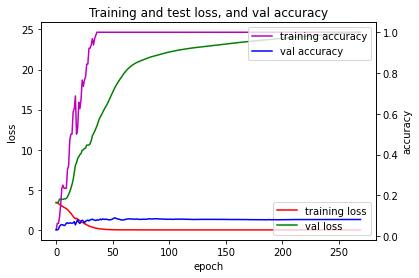

In [351]:
results_path_minibatch = "/Users/tsunyinho/Desktop/assement1_AI/comp5623m-2022/result/cnnclassifierepochs.pt"
data = torch.load(results_path_minibatch)
statsrec = data["stats"]
fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'g', label = 'val loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and test loss, and val accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[1], 'm', label = 'training accuracy')
ax2.plot(statsrec[3], 'b', label = 'val accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper right')
fig.savefig("roc.svg")
plt.show()



## 1.2 Training on complete dataset 

### 1.2.1 Train CNN and show loss graph 

Train your model on the complete training dataset, and use the validation set to determine when to stop training.

Display the graph of training and validation loss over epochs to show how you determined the optimal number of training epochs.

> As in previous sections, please leave the graph clearly displayed.


In [15]:
# TO COMPLETE
#using full training set version
nepochs = 50
statsrec = np.zeros((4,nepochs))
results_path="/Users/tsunyinho/Desktop/assement1_AI/comp5623m-2022/result/fulltrainsetcnnclassifierepochs.pt"
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001, weight_decay=0.05)


for epoch in range(nepochs):  # loop over the dataset multiple times
    correct = 0          # number of examples predicted correctly (for accuracy)
    total = 0            # number of examples
    running_loss = 0.0   # accumulated loss (for mean loss)
    n = 0                # number of minibatches
    for data in Training_dataloader :
        inputs, labels = data
        
         # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        # accumulate loss
        running_loss += loss.item()
        n += 1
        # accumulate data for accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)    # add in the number of labels in this minibatch
        correct += (predicted == labels).sum().item()  # add in the number of correct labels
        #print(correct)
    # collect together statistics for this epoch
    ltrn = running_loss/n
    atrn = correct/total
    #print(ltrn)
    ltst, atst = stats(Val_dataloader, net)
    statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
    if(ltrn<=0.001):
        break
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%} val loss: {ltst: .3f} val accuracy: {atst: .1%}")
     
# save network parameters, losses and accuracy
torch.save({"state_dict": net.state_dict(), "stats": statsrec}, results_path)

epoch: 0 training loss:  3.881 training accuracy:  8.9% val loss:  3.078 val accuracy:  12.5%
epoch: 1 training loss:  2.985 training accuracy:  15.3% val loss:  2.912 val accuracy:  18.0%
epoch: 2 training loss:  2.863 training accuracy:  18.6% val loss:  2.865 val accuracy:  19.3%
epoch: 3 training loss:  2.772 training accuracy:  21.6% val loss:  2.797 val accuracy:  21.7%
epoch: 4 training loss:  2.685 training accuracy:  24.2% val loss:  2.733 val accuracy:  22.9%
epoch: 5 training loss:  2.584 training accuracy:  26.6% val loss:  2.699 val accuracy:  24.1%
epoch: 6 training loss:  2.475 training accuracy:  29.2% val loss:  2.631 val accuracy:  26.3%
epoch: 7 training loss:  2.364 training accuracy:  32.5% val loss:  2.673 val accuracy:  25.3%
epoch: 8 training loss:  2.257 training accuracy:  35.0% val loss:  2.618 val accuracy:  27.4%
epoch: 9 training loss:  2.141 training accuracy:  37.8% val loss:  2.664 val accuracy:  26.6%
epoch: 10 training loss:  2.035 training accuracy: 

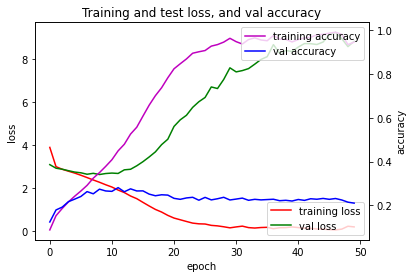

In [91]:
results_path_fulltraining = "/Users/tsunyinho/Desktop/assement1_AI/comp5623m-2022/result/fulltrainsetcnnclassifierepochs.pt"
data = torch.load(results_path_fulltraining)
statsrec = data["stats"]
fig,ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'g', label = 'val loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and test loss, and val accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[1], 'm', label = 'training accuracy')
ax2.plot(statsrec[3], 'b', label = 'val accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper right')
fig.savefig("roc.svg")
plt.show()


### 1.2.2 Finetuning 

Now finetune your architecture by implementing at least 2 methods of reducing overfitting and increasing the model's ability to generalise. You are encouraged to further adjust the model after you have done the minimum requirement, to increase your model performance. Please do not use any pre-trained weights from a model trained on ImageNet.


**Method 1:** Data augmentation of your choice

**Method 2:** Adding dropout and/or batch normalisation to the model

If you adjust the Model class, redefine it below and instantiate it as ```model_122a```, ```model_122b```, and so on.



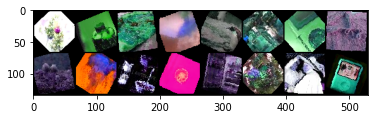

In [432]:
#transform photo(Data augmentation)
trnsfrm = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomRotation(50),
    transforms.RandomHorizontalFlip(p=0.5),
])

#Splited training version of batch size16
My_training_set_splited = LoadFromFolder(train_dir,train_set,transform=trnsfrm)
Training_dataloader_splited = DataLoader(My_training_set_splited,batch_size=16,shuffle=True)

#show out the image after doing the augmentation
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()
    
# get some random training images using the data loader
dataiter = iter(Training_dataloader_splited)
images, labels = dataiter.next()

# show images after doing the data augmentation
timshow(torchvision.utils.make_grid(images))



In [353]:
# instantiate your new Model class
# model_122a
#by using dropout+BatchNorm and added one more layer
class model_122a(nn.Module):
   def __init__(self):

      super(model_122a,self).__init__()
      self.conv1 = nn.Conv2d(in_channels=3,out_channels=16, kernel_size=7)
      self.conv1_bn=nn.BatchNorm2d(16)
      self.conv2=nn.Conv2d(in_channels=16,out_channels=32, kernel_size=5) 
      self.conv2_bn=nn.BatchNorm2d(32)
      self.conv3=nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
      self.conv3_bn=nn.BatchNorm2d(64)

      
      
      self.linear1 = nn.Linear(64*4*4, 600)
      self.linear2 = nn.Linear(600,128) 
      self.linear_out = nn.Linear(128,30)

      self.dropout = nn.Dropout(0.25)
      
   def forward(self, t):
      #input layer
      t = t
        
      #1 layer
      t=self.conv1(t)
      t=self.conv1_bn(t)
      t=F.relu(t)
      t=F.max_pool2d(t,kernel_size=2, stride=2)
       
       
      #2 layer
      t=self.conv2(t)
      t=self.conv2_bn(t)
      t=F.relu(t)
      t=F.max_pool2d(t,kernel_size=2, stride=2)
      
      #3 layer
      t=self.conv3(t)
      t=self.conv3_bn(t)
      t=F.relu(t)
      t=F.max_pool2d(t,kernel_size=2, stride=2)
      
      #dropout layer
      t=self.dropout(t)
      t=torch.flatten(t,1)
      
      #fully connected layer
      t=self.linear1(t)
      t=F.relu(t)
      t=self.linear2(t)
      t=F.relu(t)

      #output layer
      t=self.linear_out(t)
      
      return t
      

model_a = model_122a()

In [354]:
#finetune training with the finetune cnn version 1 (model_122a)
nepochs = 120
statsrec = np.zeros((4,nepochs))
results_path="/Users/tsunyinho/Desktop/assement1_AI/comp5623m-2022/result/finaltrainsetcnnclassifierepochs.pt"
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_a.parameters(), lr=0.0001, weight_decay=0.07)


for epoch in range(nepochs):  
    correct = 0          
    total = 0            
    running_loss = 0.0   
    n = 0               
    for data in Training_dataloader_splited:
        inputs, labels = data
        
        
        optimizer.zero_grad()

        
        outputs = model_a(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    
        running_loss += loss.item()
        n += 1

     
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)    
        correct += (predicted == labels).sum().item()  
       

    ltrn = running_loss/n
    atrn = correct/total
   
    ltst, atst = stats(Val_dataloader, model_a)
    statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
    
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%} val loss: {ltst: .3f} val accuracy: {atst: .1%}")
     

torch.save({"state_dict": model_a.state_dict(), "stats": statsrec}, results_path)

epoch: 0 training loss:  3.159 training accuracy:  11.3% val loss:  2.854 val accuracy:  18.3%
epoch: 1 training loss:  2.839 training accuracy:  18.9% val loss:  2.659 val accuracy:  23.1%
epoch: 2 training loss:  2.731 training accuracy:  22.0% val loss:  2.602 val accuracy:  24.3%
epoch: 3 training loss:  2.672 training accuracy:  23.4% val loss:  2.477 val accuracy:  28.7%
epoch: 4 training loss:  2.603 training accuracy:  25.5% val loss:  2.387 val accuracy:  31.6%
epoch: 5 training loss:  2.552 training accuracy:  26.9% val loss:  2.446 val accuracy:  27.7%
epoch: 6 training loss:  2.526 training accuracy:  27.8% val loss:  2.302 val accuracy:  32.7%
epoch: 7 training loss:  2.485 training accuracy:  28.7% val loss:  2.379 val accuracy:  31.3%
epoch: 8 training loss:  2.450 training accuracy:  29.7% val loss:  2.243 val accuracy:  34.6%
epoch: 9 training loss:  2.423 training accuracy:  29.8% val loss:  2.295 val accuracy:  34.0%
epoch: 10 training loss:  2.400 training accuracy:

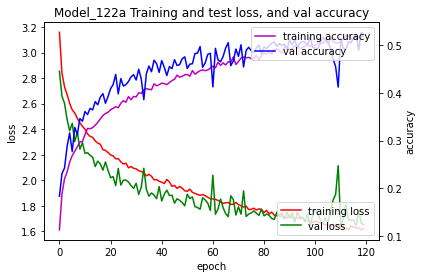

In [355]:
results_path1 = "/Users/tsunyinho/Desktop/assement1_AI/comp5623m-2022/result/finaltrainsetcnnclassifierepochs.pt"
data = torch.load(results_path1)
statsrec = data["stats"]
fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'g', label = 'val loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Model_122a Training and test loss, and val accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[1], 'm', label = 'training accuracy')
ax2.plot(statsrec[3], 'b', label = 'val accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper right')
fig.savefig("roc.svg")
plt.show()

In [81]:
#model_122b add one more layer
class model_122b(nn.Module):
   def __init__(self):

      super(model_122b,self).__init__()
      self.conv1 = nn.Conv2d(in_channels=3,out_channels=32, padding =3,kernel_size=5)
      self.conv1_bn=nn.BatchNorm2d(32)
      self.conv2=nn.Conv2d(in_channels=32,out_channels=64, padding=3,kernel_size=4) 
      self.conv2_bn=nn.BatchNorm2d(64)
      self.conv3=nn.Conv2d(in_channels=64, out_channels=128, padding=2,kernel_size=3)
      self.conv3_bn=nn.BatchNorm2d(128)
      self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
      self.conv4_bn = nn.BatchNorm2d(256)
      
      
      self.linear1 = nn.Linear(256*4*4, 1080)
      self.linear2 = nn.Linear(1080,512) 
      self.linear3 = nn.Linear(512,128)
      self.linear_out = nn.Linear(128,30)

      self.dropout = nn.Dropout(0.3)
      
   def forward(self, t):
      #input layer
      t = t
        
      #1 layer
      t=self.conv1(t)
      t=self.conv1_bn(t)
      t=F.relu(t)
      t=F.max_pool2d(t,kernel_size=2, stride=2)
       
       
      #2 layer
      t=self.conv2(t)
      t=self.conv2_bn(t)
      t=F.relu(t)
      t=F.max_pool2d(t,kernel_size=2, stride=2)
      
      #3 layer
      t=self.conv3(t)
      t=self.conv3_bn(t)
      t=F.relu(t)
      t=F.max_pool2d(t,kernel_size=2, stride=2)

      #4 layer
      t=self.conv4(t)
      t=self.conv4_bn(t)
      t=F.relu(t)
      t=F.max_pool2d(t,kernel_size=2, stride=2)
      
      #dropout layer
      t=self.dropout(t)
      t=torch.flatten(t,1)
      
      #fully connected layer
      t=self.linear1(t)
      t=F.relu(t)
      t=self.linear2(t)
      t=F.relu(t)
      t=self.linear3(t)
      t=F.relu(t)
      

      #output layer
      t=self.linear_out(t)
      
      return t
      

model_b = model_122b()

In [82]:
#finetune training with the finetune cnn version 2
nepochs = 120
statsrec = np.zeros((4,nepochs))
results_path="/Users/tsunyinho/Desktop/assement1_AI/comp5623m-2022/result/final_ver2_trainsetcnnclassifierepochs.pt"
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_b.parameters(), lr=0.0001, weight_decay=0.005)


for epoch in range(nepochs):  
    correct = 0          
    total = 0            
    running_loss = 0.0   
    n = 0                
    for data in Training_dataloader_splited:
        inputs, labels = data
        
         
        optimizer.zero_grad()

        outputs = model_b(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        n += 1
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)    
        correct += (predicted == labels).sum().item()  
       
    ltrn = running_loss/n
    atrn = correct/total
  
    ltst, atst = stats(Val_dataloader, model_b)
    statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%} val loss: {ltst: .3f} val accuracy: {atst: .1%}")
     

torch.save({"state_dict": model_b.state_dict(), "stats": statsrec}, results_path)

epoch: 0 training loss:  3.137 training accuracy:  11.2% val loss:  2.907 val accuracy:  17.3%
epoch: 1 training loss:  2.768 training accuracy:  19.9% val loss:  2.536 val accuracy:  25.2%
epoch: 2 training loss:  2.609 training accuracy:  24.2% val loss:  2.481 val accuracy:  27.0%
epoch: 3 training loss:  2.489 training accuracy:  27.7% val loss:  2.348 val accuracy:  32.0%
epoch: 4 training loss:  2.413 training accuracy:  29.2% val loss:  2.359 val accuracy:  31.6%
epoch: 5 training loss:  2.341 training accuracy:  31.7% val loss:  2.229 val accuracy:  35.3%
epoch: 6 training loss:  2.289 training accuracy:  32.6% val loss:  2.203 val accuracy:  34.9%
epoch: 7 training loss:  2.223 training accuracy:  34.7% val loss:  2.108 val accuracy:  37.9%
epoch: 8 training loss:  2.174 training accuracy:  36.0% val loss:  2.135 val accuracy:  38.9%
epoch: 9 training loss:  2.135 training accuracy:  37.8% val loss:  2.004 val accuracy:  41.9%
epoch: 10 training loss:  2.104 training accuracy:

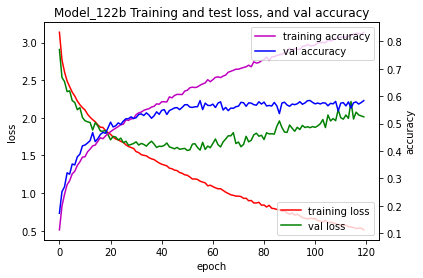

In [154]:
results_path2 = "/Users/tsunyinho/Desktop/assement1_AI/comp5623m-2022/result/final_ver2_trainsetcnnclassifierepochs.pt"
data = torch.load(results_path2)
statsrec = data["stats"]
fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'g', label = 'val loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Model_122b Training and test loss, and val accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[1], 'm', label = 'training accuracy')
ax2.plot(statsrec[3], 'b', label = 'val accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper right')
fig.savefig("roc.svg")
plt.show()


### 1.2.3 Training comparison 

Display, side-by-side or on one single graph, the training and validation loss graphs for the single-batch training (section 1.1.3), on the full training set (1.2.1) and your final fine-tuned model (1.2.2). 

Text(0.5, 0.01, 'epoch')

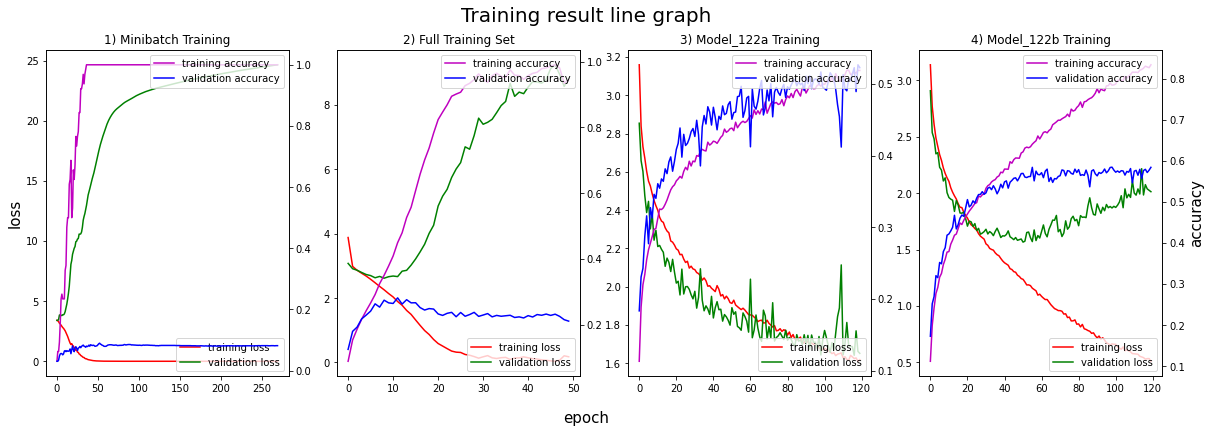

In [617]:
#compare 4 training graph that included (section 1.1.3 , 1.2.1 ,1.2.2)

result = [results_path_minibatch, results_path_fulltraining, results_path1, results_path2]

data1 = torch.load(result[0])
data2 = torch.load(result[1])
data3 = torch.load(result[2])
data4 = torch.load(result[3])

statsrec1 = data1["stats"]
statsrec2 = data2["stats"]
statsrec3 = data3["stats"]
statsrec4 = data4["stats"]
fig, (ax1, ax3, ax5, ax7) = plt.subplots(1,4,figsize=(20,6))


#plot 1.1.3 graph
ax1.set_ylabel('loss',fontsize=15)
ax1.plot(statsrec1[0], 'r', label = 'training loss', )
ax1.plot(statsrec1[2], 'g', label = 'validation loss' )
ax1.legend(loc='lower right')
ax2=ax1.twinx()
ax2.plot(statsrec1[1], 'm', label = 'training accuracy')
ax2.plot(statsrec1[3], 'b', label = 'validation accuracy')
ax2.legend(loc='upper right')
plt.title("1) Minibatch Training")


#plot 1.2.1 graph
ax3.plot(statsrec2[0], 'r', label = 'training loss', )
ax3.plot(statsrec2[2], 'g', label = 'validation loss' )
ax3.legend(loc='lower right')
ax4=ax3.twinx()
ax4.plot(statsrec2[1], 'm', label = 'training accuracy')
ax4.plot(statsrec2[3], 'b', label = 'validation accuracy')
ax4.legend(loc='upper right')
plt.title("2) Full Training Set")


#plot 1.2.2 graph model_122a
ax5.plot(statsrec3[0], 'r', label = 'training loss', )
ax5.plot(statsrec3[2], 'g', label = 'validation loss' )
ax5.legend(loc='lower right')
ax6=ax5.twinx()
ax6.plot(statsrec3[1], 'm', label = 'training accuracy')
ax6.plot(statsrec3[3], 'b', label = 'validation accuracy')
ax6.legend(loc='upper right')
plt.title('3) Model_122a Training')

#plot 1.2.2.graph model_122b
ax7.plot(statsrec4[0], 'r', label = 'training loss', )
ax7.plot(statsrec4[2], 'g', label = 'validation loss' )
ax7.legend(loc='lower right')
ax8=ax7.twinx()
ax8.plot(statsrec4[1], 'm', label = 'training accuracy')
ax8.plot(statsrec4[3], 'b', label = 'validation accuracy')
ax8.legend(loc='upper right')
plt.title('4) Model_122b Training')

ax8.set_ylabel('accuracy',fontsize=15)
fig.suptitle('Training result line graph',fontsize=20)
fig.supxlabel('epoch',fontsize=15)




Explain what can be seen in the graphs.

--> Double click here to respond

The Minibatch training and full traing set graph show the training results are overfitting, because the line of validation loss is far away from training loss. The line of validation accuracy and the training accuracy are also far away from each other. However, for model_122a and model_122b, although the lines are zizag, the results show that are not overfitting. For the model_122b, the training epoch might need to be reduced in order to make the validation loss and training loss stick together, also both the training and validation accuracy stick with each other.


### 1.2.4 Confusion matrices 

Use your architecture with best accuracy to generate two confusion matrices, one for the training set and one for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way which clearly indicates what percentage of the data is represented in each position.



In [155]:
# TO COMPLETE
def accuracy(cnfm):
    return cnfm.trace()/cnfm.sum((0,1))

def recalls(cnfm):
    return np.diag(cnfm)/cnfm.sum(1)

def precisions(cnfm):
    return np.diag(cnfm)/cnfm.sum(0)  

In [156]:
#confusion matrix function
def confusion_matrix(data_set,cnfm):
    d = torch.load(results_path2)
    # now load the parameter state into the current model (make sure this is the right model).
    model_b.load_state_dict(d["state_dict"])

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_set):
            outputs = model_b(inputs)
            _, preds = torch.max(outputs, 1)
            for i in range(labels.size(0)):
                cnfm[labels[i].item(),preds[i].item()] += 1
      
    return cnfm





Train Set Accuracy: 0.787
Class: 0 : Precision 77.7%  Recall 66.1%
Class: 1 : Precision 79.1%  Recall 74.7%
Class: 2 : Precision 74.2%  Recall 79.3%
Class: 3 : Precision 82.6%  Recall 83.3%
Class: 4 : Precision 86.6%  Recall 94.5%
Class: 5 : Precision 72.8%  Recall 75.2%
Class: 6 : Precision 74.4%  Recall 81.2%
Class: 7 : Precision 67.8%  Recall 77.0%
Class: 8 : Precision 80.9%  Recall 76.4%
Class: 9 : Precision 78.6%  Recall 87.2%
Class: 10 : Precision 80.5%  Recall 76.9%
Class: 11 : Precision 81.3%  Recall 86.6%
Class: 12 : Precision 74.7%  Recall 78.1%
Class: 13 : Precision 81.7%  Recall 79.8%
Class: 14 : Precision 80.1%  Recall 76.5%
Class: 15 : Precision 66.4%  Recall 70.1%
Class: 16 : Precision 77.1%  Recall 75.8%
Class: 17 : Precision 85.3%  Recall 89.9%
Class: 18 : Precision 63.3%  Recall 87.6%
Class: 19 : Precision 88.7%  Recall 78.8%
Class: 20 : Precision 86.9%  Recall 72.1%
Class: 21 : Precision 88.4%  Recall 75.3%
Class: 22 : Precision 83.5%  Recall 85.8%
Class: 23 : Precis

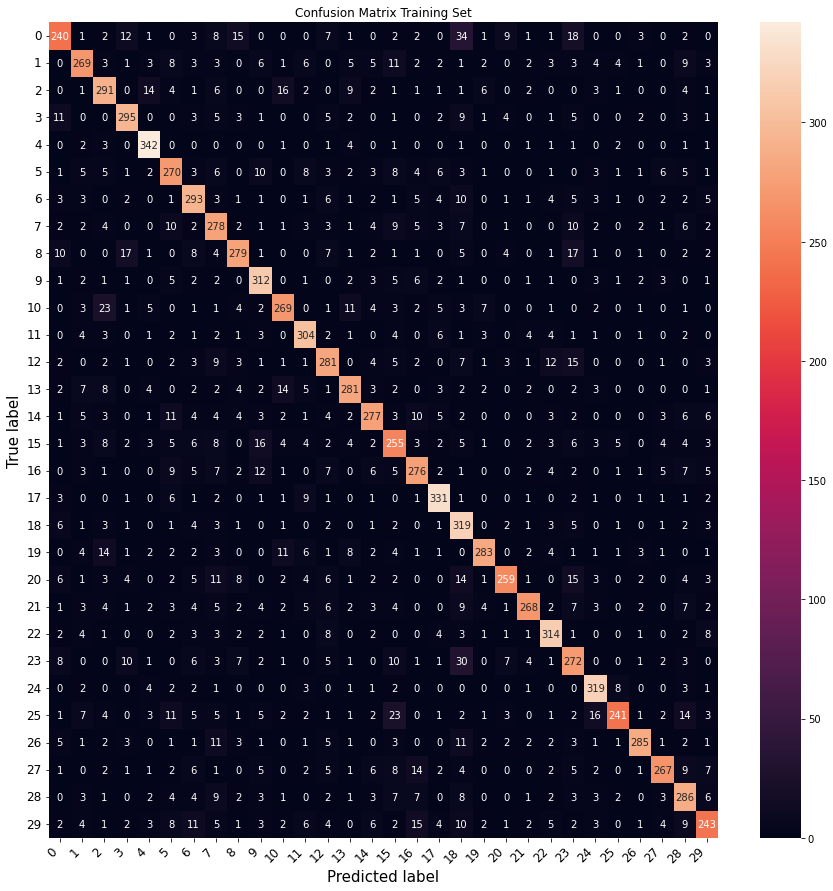

In [626]:
#training set information
nb_classes = 30
classes = np.arange(0, 30)
cnfm = np.zeros((nb_classes, nb_classes),dtype=int)
c_matrix=confusion_matrix(Training_dataloader_splited,cnfm)
plt.figure(figsize=(15,15))
df_cm = pd.DataFrame(c_matrix, index=classes, columns=classes).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=12)
plt.title("Confusion Matrix Training Set",fontsize=12)
plt.ylabel('True label',fontsize=15)
plt.xlabel('Predicted label',fontsize=15)


#print accuracy, recalls and precisions
print(f"Train Set Accuracy: {accuracy(c_matrix) :.3f}")
nclasses = classes.shape[0]
r = recalls(c_matrix)
p = precisions(c_matrix)

for i in range(nclasses):
    print(f"Class: {classes[i]} : Precision {p[i] :.1%}  Recall {r[i] :.1%}")


Val Set Accuracy: 0.857
Class: 0 : Precision 84.0%  Recall 78.2%
Class: 1 : Precision 89.4%  Recall 84.4%
Class: 2 : Precision 82.9%  Recall 81.9%
Class: 3 : Precision 83.8%  Recall 91.7%
Class: 4 : Precision 90.5%  Recall 97.7%
Class: 5 : Precision 75.3%  Recall 80.2%
Class: 6 : Precision 83.7%  Recall 86.5%
Class: 7 : Precision 84.6%  Recall 86.5%
Class: 8 : Precision 92.1%  Recall 82.4%
Class: 9 : Precision 78.6%  Recall 88.0%
Class: 10 : Precision 93.3%  Recall 84.0%
Class: 11 : Precision 91.8%  Recall 89.9%
Class: 12 : Precision 81.2%  Recall 86.7%
Class: 13 : Precision 91.0%  Recall 82.7%
Class: 14 : Precision 81.2%  Recall 88.6%
Class: 15 : Precision 76.2%  Recall 74.4%
Class: 16 : Precision 75.5%  Recall 86.0%
Class: 17 : Precision 86.5%  Recall 93.9%
Class: 18 : Precision 82.5%  Recall 93.0%
Class: 19 : Precision 91.2%  Recall 91.2%
Class: 20 : Precision 98.6%  Recall 75.8%
Class: 21 : Precision 94.3%  Recall 88.3%
Class: 22 : Precision 88.9%  Recall 95.2%
Class: 23 : Precisio

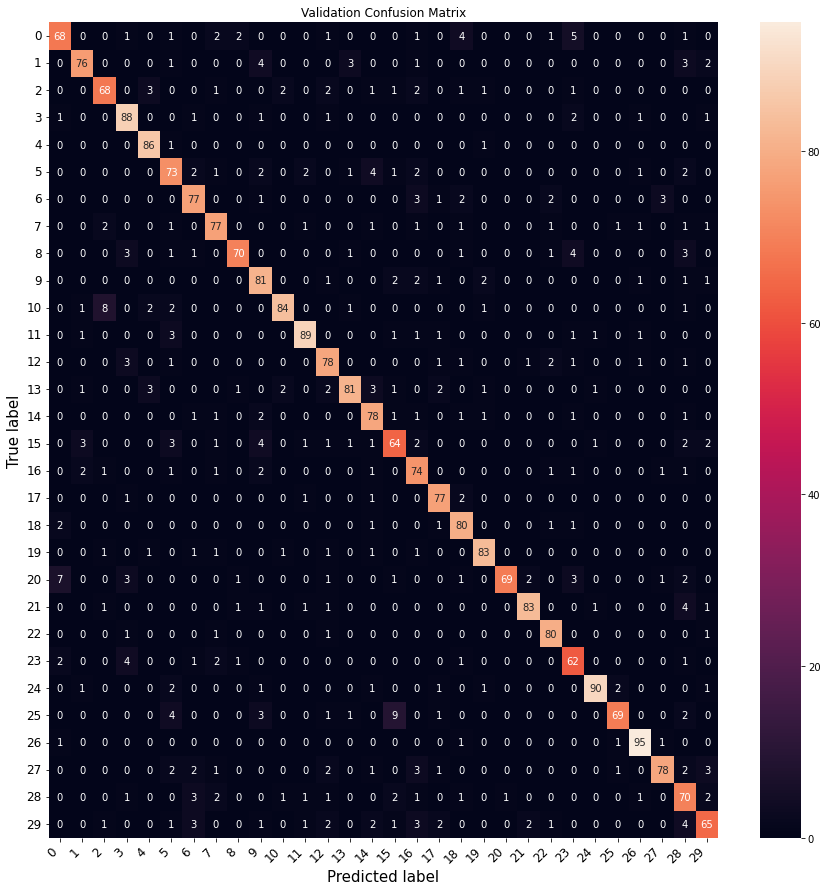

In [618]:
#Validation set confusion matrix
cnfm1 = np.zeros((nb_classes, nb_classes),dtype=int)
val_matrix=confusion_matrix(Val_dataloader,cnfm1)
plt.figure(figsize=(15,15))
df_cm = pd.DataFrame(val_matrix, index=classes, columns=classes).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=12)
plt.ylabel('True label',fontsize=15)
plt.xlabel('Predicted label',fontsize=15)
plt.title("Validation Confusion Matrix",fontsize=12)

#accuracy, recall, precision
print(f"Val Set Accuracy: {accuracy(val_matrix) :.3f}")
nclasses1 = classes.shape[0]
r1 = recalls(val_matrix)
p1 = precisions(val_matrix)

for i in range(nclasses1):
    print(f"Class: {classes[i]} : Precision {p1[i] :.1%}  Recall {r1[i] :.1%}")

What conclusions can be drawn from the confusion matrices?

---> Double click to respond here

The confusion matrix of training set shows how is the model learned by using the training set. 
The confusion matrix of validation set shows that number of the prediction of class 26 have the highest prediction accuracy. However, the truth label of class 25 label got 9 times wrong for predicting as 15 class, which is the highest error in the confusion matrix. 



## 1.3 Testing on test data 

### 1.3.1 Dataset and generating predictions 

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. 


In [216]:
# TO COMPLETE
#use all the dataset in test dataloader 

Test_dataloader = DataLoader(My_test_set,batch_size=1,shuffle=False)

#test data fuction
def prediction(data_set,model):
    prediction=[]
    model.eval()
    with torch.no_grad():
        for inputs in data_set:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            prediction.append(int(preds[0]))
        return prediction
        
p=prediction(Test_dataloader,model_b)



### 1.3.2 CSV file and test set accuracy

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, ie., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image on test set and 1 row for the headers.

> You may submit multiple times. We will use your personal top entry for allocating marks for this [10 marks]. The class leaderboard will not affect marking (brownie points!).



In [215]:
data = {'Id': test_set, 'Category': p}
final_test_data = pd.DataFrame(data)
final_test_data
final_test_data.to_csv(ROOT+'ml20tyhjasper.csv', index=False)
pd.read_csv(ROOT+'ml20tyhjasper.csv')

,Id,Category
0,c5693b7d_ab8f.JPEG,23
1,9e70a764_2962.JPEG,20
2,b54e8c45_5503.JPEG,18
3,fe6b0876_df17.JPEG,16
4,e57c80f8_247c.JPEG,1
...,...,...
1495,b63a5d25_d8cb.JPEG,14
1496,3af31804_7970.JPEG,0
1497,4e3f5caf_7840.JPEG,4
1498,76e43404_ba33.JPEG,4




## QUESTION 2 



In this question, you will visualize the filters and feature maps of a fully-trained CNN (AlexNet) on the full ImageNet 2012 dataset.

> Please do not alter the name of the function or the number and type of its arguments and return values, otherwise the automatic grading function will not work correctly. You are welcome to import other modules (though the simplest solution only requires the ones below).


### **Overview:**
*   **2.1.1** Extract filters from model: ``fetch_filters(layer_idx, model)``
*   **2.2.1** Load test image
*   **2.2.2** Extract feature maps for given test image: ``fetch_feature_maps(image, model)``
*   **2.2.3** Display feature maps
*   **2.3.1** Generate Grad-CAM heatmaps: ``generate_heatmap(output, class_id, model, image)``
*   **2.3.2** Display heatmaps: add code to cell
*   **2.3.3** Generate heatmaps for failure analysis


### Loading a pre-trained model

Run the cell below to load an AlexNet model with pre-trained weights.

In [218]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model.eval()


Using cache found in /Users/tsunyinho/.cache/torch/hub/pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [219]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [220]:
model.features[0]

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

In [221]:
model.features[0].weight.shape

torch.Size([64, 3, 11, 11])


## 2.1 Extract and visualize the filters 

In this section you will extract and visualize the filters from the pre-trained AlexNet.

### 2.1.1 Extract filters 

Complete the following function ```fetch_filters``` to return all the filters from the convolutional layers at the given index in ```model.features``` (see printed model above for reference). 





> We will not test the behaviour of your function using invalid indices.



In [228]:
def fetch_filters(layer_idx, model):
    

    """ 
        Args:
            layer_idx (int): the index of model.features specifying which conv layer
            model (AlexNet): PyTorch AlexNet object
        Return:
            filters (Tensor):      
    """
    filters = model.features[layer_idx].weight
    return filters

In [229]:
# all the indices of the conv layers
conv_layer_idx = [0, 3, 6, 8, 10]

filters = []

for layer_idx in conv_layer_idx:
    filters.append(fetch_filters(layer_idx, model))

For your testing purposes, the following code blocks test the dimensions of the function output.

In [230]:
filters[0].shape

torch.Size([64, 3, 11, 11])

In [231]:
assert list(filters[0].shape) == [64, 3, 11, 11]



### 2.1.2 Display filters 

The following code will visualize some of the filters from each layer. Play around with viewing filters at different depths into the network. Note that ```filters[0]``` could be viewed in colour if you prefer, whereas the subsequent layers must be viewed one channel at a time in grayscale. 



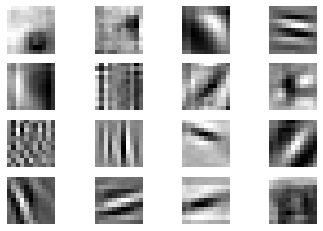

In [539]:
# limit how many filters to show
to_show = 16

# compute the dimensions of the plot
plt_dim = int(math.sqrt(to_show))

# plot the first channel of each filter in a grid
for i, filt in enumerate(filters[0].detach().numpy()[:to_show]):
    plt.subplot(plt_dim, plt_dim, i+1)
    plt.imshow(filt[0], cmap="gray")
    plt.axis('off')
plt.show()



## 2.2 Extract and visualize feature maps 

In this section, you will pass a test image through the AlexNet and extract and visualize the resulting convolutional layer feature maps.

Complete the following code cell to load the test image ```man_bike.JPEG```.



### 2.2.1 Load test image 


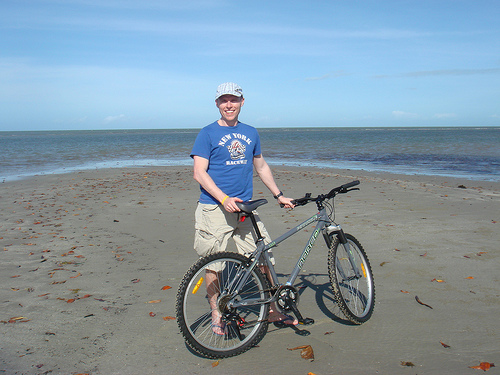

In [540]:
# TO COMPLETE
path = "/Users/tsunyinho/Desktop/assement1_AI/comp5623m-2022/man_bike.jpeg"
im = Image.open(path).convert('RGB')
im

Run the code cell below to apply the image transformation expected by the model.

In [541]:
# ImageNet normalisation values, to apply to the image transform
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

im = data_transform(im)


### 2.2.2 Extract feature maps 

Complete the function below to pass the test image through a single forward pass of the network. We are interested in the outputs of the max pool layers (outputs of conv layers at model.features indices 0, 3, and 10) for best visualization. Note that the input should pass through *every layer* of the model.

In [542]:
def fetch_feature_maps(image, model):
    feature_maps=[]
    t = model.features[0](image)
    t = model.features[1](t)
    t = model.features[2](t)
    feature_maps.append(t)
    t = model.features[3](t)
    t = model.features[4](t)
    t = model.features[5](t)
    feature_maps.append(t)
    t = model.features[6](t)
    t = model.features[7](t)
    t = model.features[8](t)
    t = model.features[9](t)
    t = model.features[10](t)
    t = model.features[11](t)
    t = model.features[12](t)
    feature_maps.append(t)
    
   
    """
    Args:
        image (Tensor): a single input image with transform applied
        model (AlexNet): PyTorch AlexNet object
        
    Return:
        feature_maps (Tensor): all the feature maps from conv layers 
                    at indices 0, 3, and 10 (outputs of the MaxPool layers)
    """

    # TO COMPLETE
    return feature_maps

In [543]:
feature_maps = fetch_feature_maps(im.unsqueeze(0), model)

For your testing purposes, the following code block tests the dimensions of part of the function output. Note that the first dimension is the batch size.

In [544]:
assert len(feature_maps) == 3
assert list(feature_maps[0].shape) == [1, 64, 31, 31]



### 2.2.3 Display feature maps 

Using the code for displaying filters as reference, write code in the block below to display the outputs of the first **16 feature maps from each of the 3 max-pool layers**.

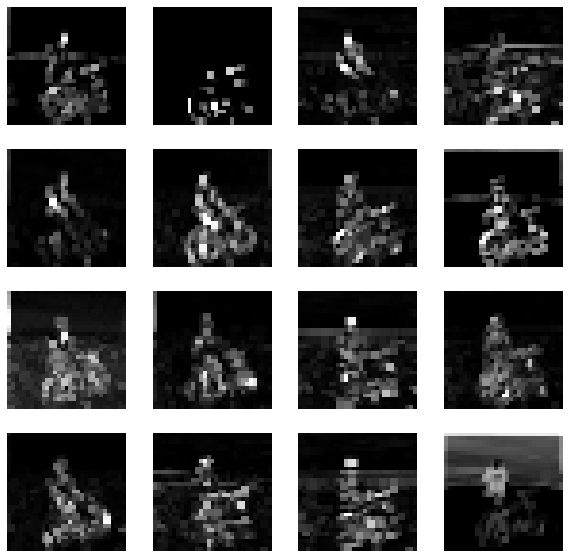

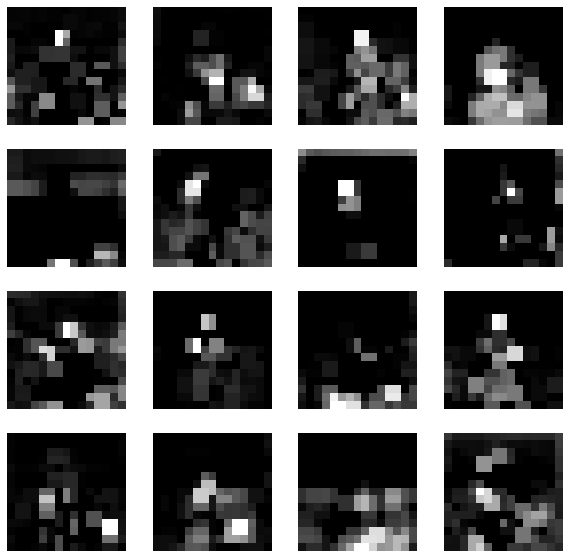

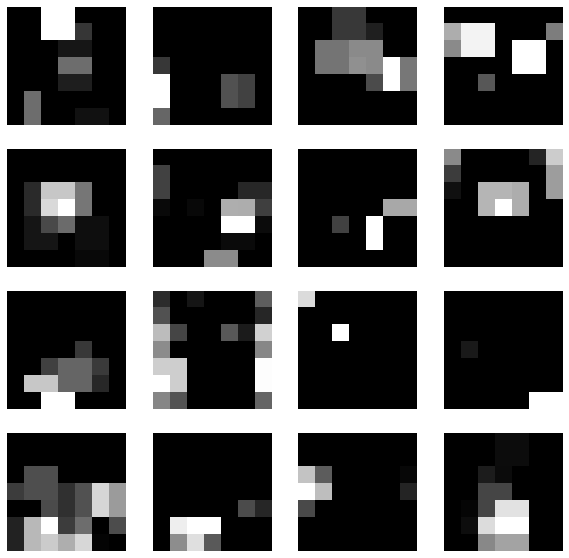

In [545]:
# TO COMPLETE
# limit how many filters to show
to_show = 16
# compute the dimensions of the plot
plt_dim = int(math.sqrt(to_show))
# plot the first channel of each filter in a grid
for i in range(len(feature_maps)):
    plt.figure(figsize=(10,10))
    for j, filt in enumerate(feature_maps[i].detach().numpy()):
        for z in range(16):
            plt.subplot(plt_dim, plt_dim, z+1)
            plt.imshow(filt[z], cmap="gray")
            plt.axis('off')
        plt.show()
    




## 2.3 Understanding of filters and feature maps 

Respond in detail to the questions below. (Note that all text boxes can be formatted using Markdown if desired).

### 2.3.1 
Describe what the three filters at indices 0, 4, and 6 from the first convolutional layer are detecting (reference the corresponding feature maps to support your discussion).


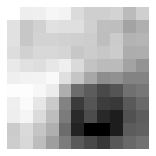

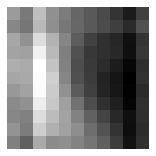

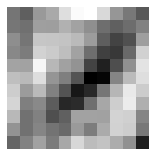

In [575]:
# limit how many filters to show
to_show = 16

# compute the dimensions of the plot
plt_dim = int(math.sqrt(to_show))

# plot the first channel of each filter in a grid
for i, filt in enumerate(filters[0].detach().numpy()[:to_show]):
    if (i==0) or (i==4) or (i==6):
        plt.figure(figsize=(12,12))
        plt.subplot(plt_dim, plt_dim, i+1)
        plt.imshow(filt[0], cmap="gray")
        plt.axis('off')
    plt.show()

--> Double click here to respond

The filter use for extracting the main characteristic of each time. After the picture that has been filtered, the feature map will be created. For the filter index of zero,four and six which is refer to the first convolution layer's feature map of index of zero, four and six. These filters are focus on man and the bike rather than the background.

### 2.3.2 
Discuss how the filters change with depth into the network.

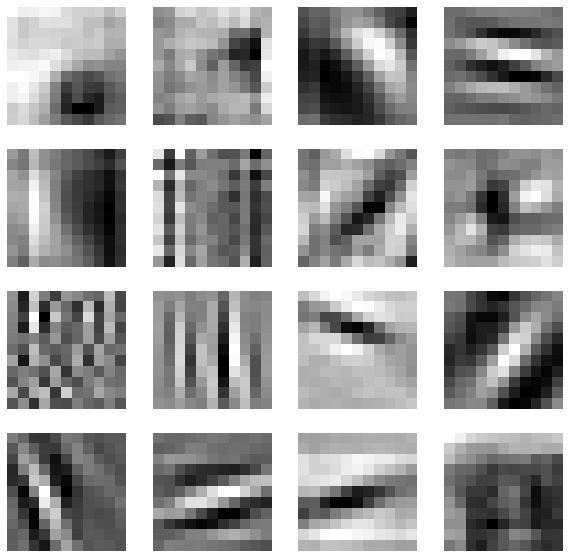

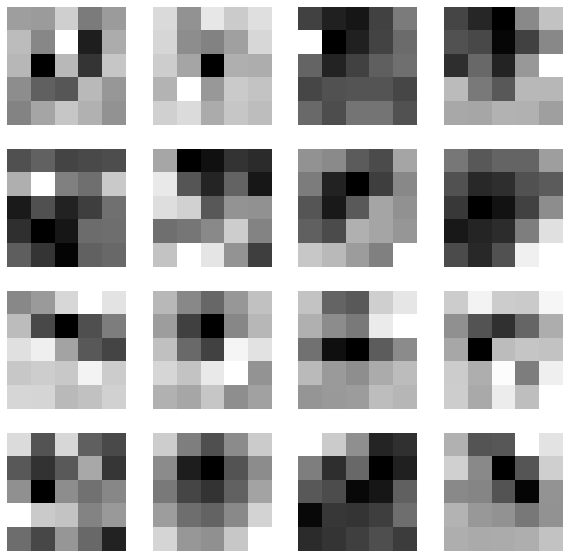

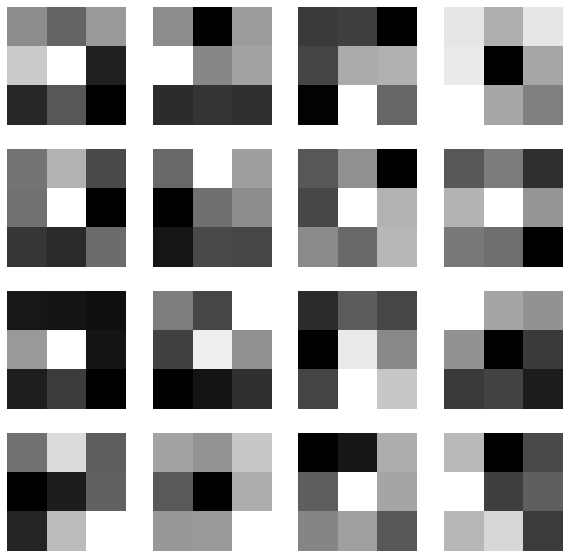

In [619]:

to_show = 16

plt_dim = int(math.sqrt(to_show))


for j in range(3):
    plt.figure(figsize=(10,10))
    for i, filt in enumerate(filters[j].detach().numpy()[:to_show]):
        plt.subplot(plt_dim, plt_dim, i+1)
        plt.imshow(filt[0], cmap="gray")
        plt.axis('off')
    plt.show()

--> Double click here to respond
 
According to the result shows above, the filter change more and more unclear, also the pixels of the filter will be come smaller when go deeper into network. That is why we can observe that the last layer shows all the filter remained 9 squares in each filter.

### 2.3.3 
Discuss how the feature maps change with depth into the network.

--> Double click here to respond

According to question 2.2.3, which shows that the feature map change more and more unclear, and the pixels of picture are gradully smaller when go deeper into the network.


## 2.4 Gradient-weighted Class Activation Mapping (Grad-CAM) 

In this section, we will explore using Gradient-weighted Class Activation Mapping (Grad-CAM) to generate coarse localization maps highlighting the important regions in the test images guiding the model's prediction. We will continue using the pre-trained AlexNet.

#### Preparation
>It is recommended to first read the relevant paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391), and refer to relevant course material.

#### The AlexNet class

>To implement Grad-CAM, we need to edit the AlexNet ```module``` class itself, so instead of loading the AlexNet model from ```torch.hub``` as we did above, we will use the official PyTorch AlexNet class code ([taken from here](https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html)). In addition to the class definition, there is also a function below called ```alexnet()``` which allows you to specify whether you want the pretrained version or not, and if so, loads the weights. 

#### The hook

>[Hooks](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) in PyTorch are functions which can be registered, or attached, to a ```Module``` or ```Tensor```. Hooks can be *forward* hooks or *backward* hooks; forward hooks are called with ```forward()``` and backward hooks with ```backward()```. In the model below, we register a forward hook that saves the **gradients of the activations** to the Tensor output of ```model.features```. The gradients are saved to a class variable so we can easily access them.

Carefully read the code block below. You do not need to add anything to the model.

In [287]:
# defining where to load the pre-trained weights from
model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-7be5be79.pth',
}

# the class definition
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        
        # a placeholder for storing the gradients
        self.gradients = None
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
    # the hook for the gradients of the activations
    def activations_hook(self, grad):
        # stores the gradients of the hook's tensor to our placeholder variable
        self.gradients = grad

    # a method for extracting the activations of the last conv layer only (when we're 
    # not interested in a full forward pass)
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        x = self.features(x)
        
        # we register the hook here to save the gradients of the last convolutional
        # layer outputs
        hook = x.register_hook(self.activations_hook)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def alexnet(pretrained=False, progress=True, **kwargs) -> AlexNet:
    """AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [288]:
model = alexnet(pretrained=True)

In [289]:
# pass our test image through our new model with the hook
output = model(im.unsqueeze(0))

# save the predicted class
_, pred_cls = output.max(dim=1, keepdim=True)

Examine and understand the values stored in ```output``` and ```pred_cls```. What does AlexNet classify the test image as?

In [290]:
print(output.shape)
print(pred_cls)

torch.Size([1, 1000])
tensor([[671]])


### 2.4.1 Generate Grad-CAM heatmaps 

With the hooks in place, now implement the code to generate Grad-CAM heatmaps, by following the guiding comments in the code block below.

In [291]:
def generate_heatmap(output, class_id, model, image):
    
    # 1. compute the gradient of the score for the predicted class (logit)
    # with respect to the feature map activations of the last convolutional layer
    # Hint: calling .backward() on a Tensor computes its gradients
    # TO COMPLETE
    output[0][class_id].backward()
    # 2. get the gradients from the model placeholder variable
    # TO COMPLETE
    gradients = model.get_activations_gradient()
    assert list(gradients.shape) == [1, 256, 7, 7]
    
    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    assert list(pooled_gradients.shape) == [256]
    
    # 3. get the activations of the last convolutional layer
    # TO COMPLETE
  
    activations = model.get_activations(image).detach()
    assert list(activations.shape) == [1, 256, 7, 7]
    
    # 4. weight (multiply) the channels (dim=1 of activations) by the corresponding
    # gradients (pooled_gradients)
    # TO COMPLETE
    for i in range(256):
      activations[:, i, :, :] *= pooled_gradients[i]
    
    # average the channels of the activations and squeeze out the extra dimension
    heatmap = torch.mean(activations, dim=1).squeeze()
    assert list(heatmap.shape) == [7, 7]
    
    # 5. apply a ReLU to the linear combination of maps because we are only 
    # interested in the features that have a positive influence on the class of 
    # interest, i.e. pixels whose intensity should be increased in order to increase y
    # Hint: you can use np.maximum() and torch.max() to perform ReLU if you prefer.
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    # TO COMPLETE
    return heatmap

In [367]:
heatmap = generate_heatmap(output, pred_cls, model, im.unsqueeze(0))
heatmap

tensor([[0.1438, 0.1814, 0.2626, 0.2394, 0.1612, 0.0962, 0.1282],
        [0.1038, 0.1900, 0.5692, 0.4835, 0.2212, 0.0950, 0.1580],
        [0.0297, 0.0742, 0.3255, 0.3797, 0.1675, 0.0177, 0.0824],
        [0.0000, 0.0000, 0.0631, 0.3636, 0.4405, 0.2675, 0.0865],
        [0.0071, 0.0000, 0.3041, 0.5341, 0.5497, 0.5611, 0.3481],
        [0.0543, 0.3712, 0.6826, 0.7470, 0.6241, 0.5682, 0.3733],
        [0.2058, 0.5518, 0.9118, 1.0000, 0.6690, 0.4814, 0.3589]])

Check the dimensions of ```heatmap```. Do they make sense?

In [293]:
heatmap.shape

torch.Size([7, 7])

### 2.4.2 Display heatmaps 

Display ```heatmap``` as a coloured heatmap super-imposed onto the original image. To get results as shown in the paper, we recommend the following steps:

1. Resize the heatmap to match the size of the image.
2. Rescale the image to a 0-255 integer range.
3. Apply a colormap to the heatmap using ```cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)```.
4. Multiply all values of heatmap by 0.4 to reduce colour saturation.
5. Superimpose the heatmap onto the original image (Note: please perform cv2's addition - addition of two cv2 images, not numpy addition. See [here](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_core/py_image_arithmetics/py_image_arithmetics.html#:~:text=addWeighted()%20etc.-,Image%20Addition,OpenCV%20addition%20and%20Numpy%20addition.) for explanation.)
6. Normalize the image between 0-255 again.
7. Display the resulting image.

In [294]:
# TO COMPLETE
img = cv2.imread("/Users/tsunyinho/Desktop/assement1_AI/comp5623m-2022/man_bike.jpeg",cv2.IMREAD_UNCHANGED)
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite("/Users/tsunyinho/Desktop/assement1_AI/comp5623m-2022/man_bike_ver_2.jpeg", superimposed_img)

True

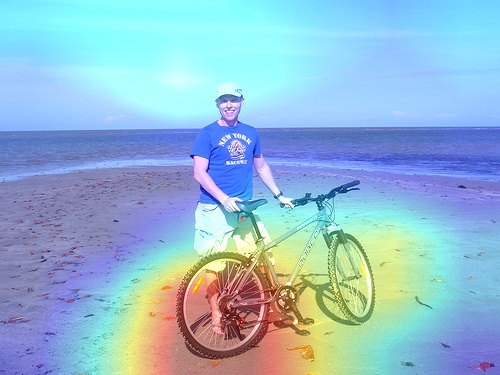

In [295]:
image = Image.open("/Users/tsunyinho/Desktop/assement1_AI/comp5623m-2022/man_bike_ver_2.jpeg").convert('RGB')
image

Show the heatmap for class ```'seashore, coast, seacoast, sea-coast'``` (```class_id = 978```), super-imposed onto the original image.

In [297]:
# TO COMPLETE
output = model(im.unsqueeze(0))
heatmap = generate_heatmap(output, 978, model, im.unsqueeze(0))

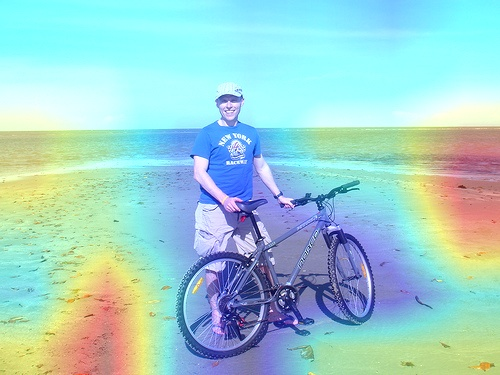

In [298]:
# TO COMPLETE
img = cv2.imread("/Users/tsunyinho/Desktop/assement1_AI/comp5623m-2022/man_bike.jpeg",cv2.IMREAD_UNCHANGED)
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite("/Users/tsunyinho/Desktop/assement1_AI/comp5623m-2022/man_bike_ver_3.jpeg", superimposed_img)
image = Image.open("/Users/tsunyinho/Desktop/assement1_AI/comp5623m-2022/man_bike_ver_3.jpeg").convert('RGB')
image

### 2.4.3 Failure analysis using Grad-CAM 

Find an image (online, or from ImageNet or another dataset) which AlexNet classifies *incorrectly*. Display the image below, and show the model's predicted class. Then, generate the Grad-CAM heatmap and display it super-imposed onto the image.

In [429]:
# TO COMPLETE
#load a csv file
file = open ('/Users/tsunyinho/Desktop/assement1_AI/comp5623m-2022/ImagenetLabels.csv',"r") 

#this part is read out the label
label = file.readlines()

test_im = Image.open("/Users/tsunyinho/Desktop/assement1_AI/comp5623m-2022/cat_dog.jpeg").convert('RGB')

"cocker spaniel, English cocker spaniel, cocker"



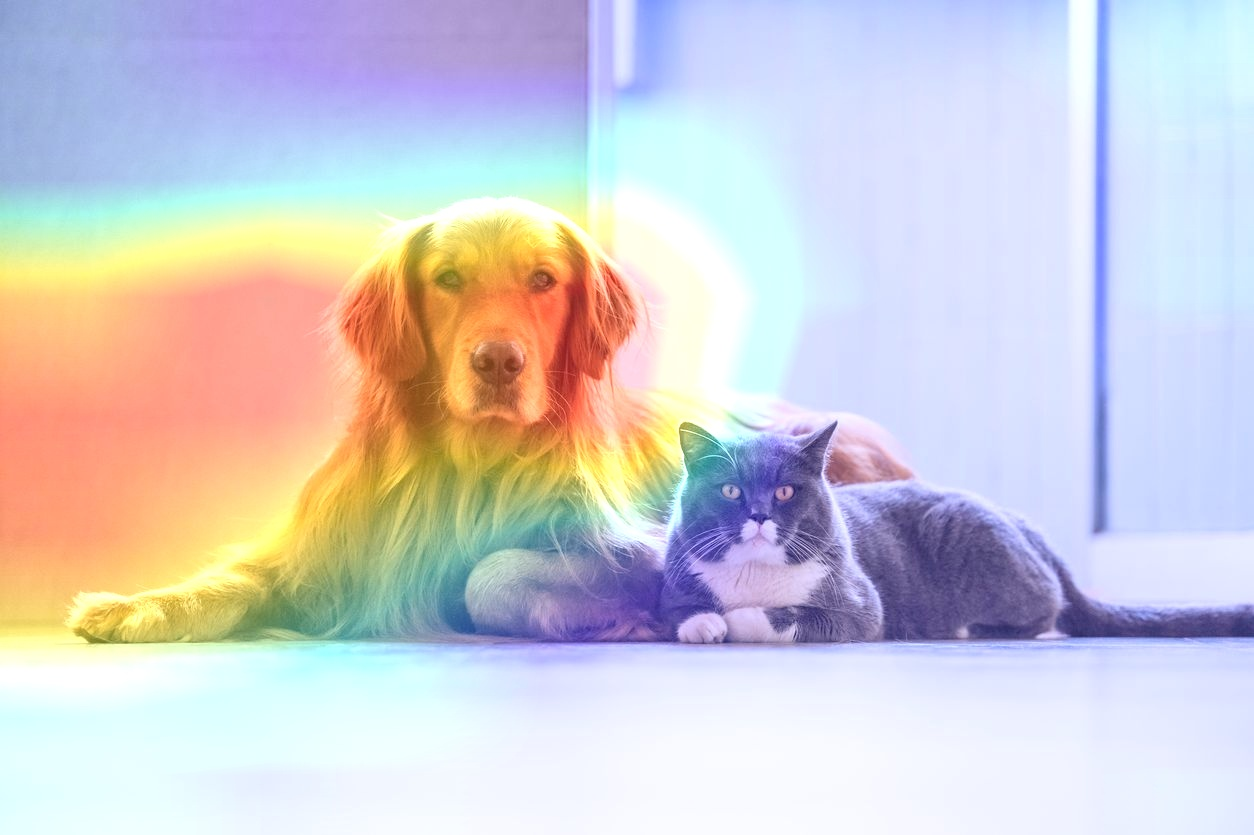

In [430]:
# TO COMPLETE

#some thing like data augmentation
test_im = data_transform(test_im)
# pass our test image through our new model with the hook
output1 = model(test_im.unsqueeze(0))
# save the predicted class
_, pred_cls = output1.max(dim=1, keepdim=True)
#put all the data into a heapmap function
last_heatmap = generate_heatmap(output1, pred_cls, model, test_im.unsqueeze(0))

last_img = cv2.imread("/Users/tsunyinho/Desktop/assement1_AI/comp5623m-2022/cat_dog.jpeg",cv2.IMREAD_UNCHANGED)
last_heatmap = np.uint8(255 * last_heatmap)
last_heatmap = cv2.resize(last_heatmap, (img.shape[1], img.shape[0]))
last_heatmap = cv2.applyColorMap(last_heatmap, cv2.COLORMAP_JET)
last_superimposed_img = last_heatmap * 0.4 + last_img
cv2.imwrite("/Users/tsunyinho/Desktop/assement1_AI/comp5623m-2022/cat_dog_test1.jpeg", last_superimposed_img)
last_image = Image.open("/Users/tsunyinho/Desktop/assement1_AI/comp5623m-2022/cat_dog_test1.jpeg").convert('RGB')

print(label[pred_cls])
last_image       


Briefly describe what explanation the Grad-CAM heatmap provides about why the model has failed to correctly classify your test image.

--> Double click to respond here

Because golden reciver are similar to cocker so, the model will recognise wrong. However, the cat is not as big as a dog, so that is why the model cannot realise there exist a cat .